<a href="https://colab.research.google.com/github/TuanNguyenDin/HR-Analytics-Job-Change/blob/main/HR_Analytics_Job_Change_of_Data_Scientists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Install the necessary libraries.

In [64]:
!pip install pymysql

In [135]:
import pandas as pd
import numpy as np
import google.colab.files as files
import pymysql
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sqlalchemy import create_engine

### 2. Load data from sources

Create functions to assist in loading data.

In [66]:
def load_data(file_path, file_type=None):

    df = None
    if file_type is None:
        if isinstance(file_path, str):
            if file_path.endswith('.csv'):
                file_type = 'csv'
            elif file_path.endswith(('.xls', '.xlsx')):
                file_type = 'excel'
            elif file_path.endswith('.json'):
                file_type = 'json'
            else:
                print(f"Could not infer file type from extension for '{file_path}'. Please provide 'file_type' argument.")
                return None
        else:
            print("Invalid file_path type. Must be a string.")
            return None

    print(f"Attempting to load data from: {file_path} as {file_type.upper()}")

    try:
        if file_type.lower() == 'csv':
            df = pd.read_csv(file_path)
        elif file_type.lower() == 'excel':
            df = pd.read_excel(file_path)
        elif file_type.lower() == 'json':
            df = pd.read_json(file_path)
        else:
            print(f"Unsupported file type: {file_type}")
            return None
        print(f"Successfully loaded data from {file_path}")
        return df
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        return None

In [67]:
def read_sql_table(db_name, db_table):
  #MySQL connection infor
  db_type = 'mysql'
  db_host = '112.213.86.31'
  db_port = '3360'
  db_user = 'etl_practice'
  db_password = '550814'

  print(f'Connecting to sql server: {db_host}:{db_port}')
  engine = create_engine(f'{db_type}+pymysql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')
  return pd.read_sql_table(db_table, engine)

Load data from various sources

In [68]:
google_sheet_id = '1VCkHwBjJGRJ21asd9pxW4_0z2PWuKhbLR3gUHm-p4GI'
enrollee_df = pd.read_excel(f'https://docs.google.com/spreadsheets/d/{google_sheet_id}/export?format=xlsx')

enrollee_df.sample(5)

,enrollee_id,full_name,city,gender
10076,13304,Mike Williams,city_21,Male
10057,20440,Chris Jones,city_138,Male
10663,28747,David Martinez,city_16,Male
18715,7523,Sarah Brown,city_67,Male
5797,11968,Alex Williams,city_71,NaN


In [69]:
file_url = 'https://assets.swisscoding.edu.vn/company_course/enrollies_education.xlsx'
enrollies_education_df=load_data(file_url)
enrollies_education_df.sample(5)

Attempting to load data from: https://assets.swisscoding.edu.vn/company_course/enrollies_education.xlsx as EXCEL
Successfully loaded data from https://assets.swisscoding.edu.vn/company_course/enrollies_education.xlsx


,enrollee_id,enrolled_university,education_level,major_discipline
11907,18016,no_enrollment,Graduate,STEM
5301,6825,no_enrollment,Masters,No Major
14846,9308,no_enrollment,Masters,STEM
11577,21778,no_enrollment,Graduate,STEM
11151,9120,Full time course,Graduate,STEM


In [70]:
url_file = 'https://assets.swisscoding.edu.vn/company_course/work_experience.csv'
work_experience_df = load_data(url_file, file_type='csv')
work_experience_df.sample(5)

Attempting to load data from: https://assets.swisscoding.edu.vn/company_course/work_experience.csv as CSV
Successfully loaded data from https://assets.swisscoding.edu.vn/company_course/work_experience.csv


,enrollee_id,relevent_experience,experience,company_size,company_type,last_new_job
9122,19305,No relevent experience,4,50-99,Funded Startup,1
6940,32390,Has relevent experience,3,NaN,NaN,1
1616,18309,No relevent experience,10,NaN,NaN,never
11270,11027,Has relevent experience,7,50-99,Pvt Ltd,4
5138,30554,Has relevent experience,4,10000+,Pvt Ltd,1


In [71]:
# MySQL connection details
db_name = 'company_course'
db_table= 'training_hours'

training_hours_df = read_sql_table(db_name, db_table)
training_hours_df.sample(5)

Connecting to sql server: 112.213.86.31:3360


,enrollee_id,training_hours
3539,10987,62
3142,18922,7
122,10555,8
9934,6753,18
12286,7111,74


In [72]:
url = 'https://sca-programming-school.github.io/city_development_index/index.html'
city_development_index_df = pd.read_html(url)[0]
city_development_index_df.head(5)

,City,City Development Index
0,city_103,0.920
1,city_40,0.776
2,city_21,0.624
3,city_115,0.789
4,city_162,0.767


In [73]:
# MySQL connection details
db_name = 'company_course'
db_table= 'employment'

employment_df = read_sql_table(db_name, db_table)
employment_df.sample(5)

Connecting to sql server: 112.213.86.31:3360


,enrollee_id,employed
5865,10510,0.0
14507,25391,1.0
1782,3269,0.0
12420,21875,0.0
296,550,0.0


### 3. Cleanning Data

These functions are created to assist in data cleaning, specifically for filling missing values and converting column data types.

In [74]:
def fill_missing_values(df,col,val):
  df[col].fillna(val, inplace=True)
  return df

In [75]:
def convert_columns_to_dtype(df, columns_to_convert, target_dtype):
    print(f"\nConverting applicable columns to '{target_dtype}' dtype...")
    for col in columns_to_convert:
        if col in df.columns:
            if df[col].dtype != target_dtype:
                try:
                    df[col] = df[col].astype(target_dtype)
                    print(f"  Converted column '{col}' to '{target_dtype}' dtype.")
                except Exception as e:
                    print(f"  Could not convert column '{col}' to '{target_dtype}' dtype: {e}")
            else:
                print(f"  Column '{col}' is already of '{target_dtype}' dtype.")
        else:
            print(f"  Column '{col}' not found in DataFrame.")
    print(f"\nUpdated DataFrame info after conversion:")
    df.info()
    return df

Check the structure and data types of `enrollee_df` to better understand it before cleaning.

In [76]:
enrollee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   enrollee_id  19158 non-null  int64 
 1   full_name    19158 non-null  object
 2   city         19158 non-null  object
 3   gender       14650 non-null  object
dtypes: int64(1), object(3)
memory usage: 598.8+ KB


Convert related columns in `enrollee_df` to string for consistency, except `enrollee_id` column.

In [77]:
# List of columns to convert to string, excluding 'enrollee_id'
columns_to_convert_enrollee = [col for col in enrollee_df.columns if col != 'enrollee_id']

enrollee_df = convert_columns_to_dtype(enrollee_df, columns_to_convert_enrollee, 'string')



Converting applicable columns to 'string' dtype...
  Converted column 'full_name' to 'string' dtype.
  Converted column 'city' to 'string' dtype.
  Converted column 'gender' to 'string' dtype.

Updated DataFrame info after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   enrollee_id  19158 non-null  int64 
 1   full_name    19158 non-null  string
 2   city         19158 non-null  string
 3   gender       14650 non-null  string
dtypes: int64(1), string(3)
memory usage: 598.8 KB


Verify that the `enrollee_id` column contains unique values, which is important for later data consolidation.

In [78]:
enrollee_df['enrollee_id'].is_unique

True

Fill missing `gender` values ​​in `enrollee_df` with 'Non-binary' to ensure complete data.

In [79]:
fill_missing_values(enrollee_df,'gender','Non-binary')
enrollee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   enrollee_id  19158 non-null  int64 
 1   full_name    19158 non-null  string
 2   city         19158 non-null  string
 3   gender       19158 non-null  string
dtypes: int64(1), string(3)
memory usage: 598.8 KB


/tmp/ipython-input-952372078.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(val, inplace=True)


Show a sample of `enrollee_df` after cleaning to review changes.

In [80]:
enrollee_df.sample(5)

,enrollee_id,full_name,city,gender
7984,16771,John Davis,city_126,Non-binary
12416,32078,Emily Smith,city_103,Non-binary
11888,4146,Emily Brown,city_103,Male
8326,13661,Chris Davis,city_41,Male
2589,26787,Jane Garcia,city_16,Non-binary


Consider `enrollies_education_df` for its structure and data types.

In [81]:
enrollies_education_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   enrollee_id          19158 non-null  int64 
 1   enrolled_university  18772 non-null  object
 2   education_level      18698 non-null  object
 3   major_discipline     16345 non-null  object
dtypes: int64(1), object(3)
memory usage: 598.8+ KB


Check uniqueness of `enrollee_id` in `enrollies_education_df`.

In [82]:
enrollies_education_df['enrollee_id'].is_unique

True

Check for unique values ​​in all columns of `enrollies_education_df` to identify potential problems or categories.

In [83]:
for col in enrollies_education_df.columns:
    print(f"Unique values in column '{col}': {enrollies_education_df[col].unique()}")

Unique values in column 'enrollee_id': [ 8949 29725 11561 ... 24576  5756 23834]
Unique values in column 'enrolled_university': ['no_enrollment' 'Full time course' nan 'Part time course']
Unique values in column 'education_level': ['Graduate' 'Masters' 'High School' nan 'Phd' 'Primary School']
Unique values in column 'major_discipline': ['STEM' 'Business Degree' nan 'Arts' 'Humanities' 'No Major' 'Other']


Convert related columns in `enrollies_education_df` to strings for consistency.

In [84]:
columns_to_convert_enrollee = [col for col in enrollies_education_df.columns if col != 'enrollee_id']
enrollies_education_df = convert_columns_to_dtype(enrollies_education_df, columns_to_convert_enrollee, 'string')


Converting applicable columns to 'string' dtype...
  Converted column 'enrolled_university' to 'string' dtype.
  Converted column 'education_level' to 'string' dtype.
  Converted column 'major_discipline' to 'string' dtype.

Updated DataFrame info after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   enrollee_id          19158 non-null  int64 
 1   enrolled_university  18772 non-null  string
 2   education_level      18698 non-null  string
 3   major_discipline     16345 non-null  string
dtypes: int64(1), string(3)
memory usage: 598.8 KB


Fill in missing values ​​in the `enrolled_university`, `education_level`, and `major_discipline` columns with appropriate default values.

In [85]:
fill_missing_values(enrollies_education_df,'enrolled_university','no_enrollment')
fill_missing_values(enrollies_education_df,'education_level','Primary School')
fill_missing_values(enrollies_education_df,'major_discipline','STEM')
enrollies_education_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   enrollee_id          19158 non-null  int64 
 1   enrolled_university  19158 non-null  string
 2   education_level      19158 non-null  string
 3   major_discipline     19158 non-null  string
dtypes: int64(1), string(3)
memory usage: 598.8 KB


/tmp/ipython-input-952372078.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(val, inplace=True)


Show a sample of `enrollies_education_df` after cleaning to review the changes.

In [86]:
enrollies_education_df.sample(5)

,enrollee_id,enrolled_university,education_level,major_discipline
1824,9801,no_enrollment,Graduate,STEM
8429,26725,no_enrollment,Masters,STEM
8479,12010,no_enrollment,Graduate,STEM
15149,31690,no_enrollment,Graduate,STEM
13175,2190,no_enrollment,Masters,STEM


Check `work_experience_df` for its structure and data types.

In [87]:
work_experience_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   enrollee_id          19158 non-null  int64 
 1   relevent_experience  19158 non-null  object
 2   experience           19093 non-null  object
 3   company_size         13220 non-null  object
 4   company_type         13018 non-null  object
 5   last_new_job         18735 non-null  object
dtypes: int64(1), object(5)
memory usage: 898.2+ KB


Check uniqueness of `enrollee_id` in `work_experience_df`.

In [88]:
work_experience_df['enrollee_id'].is_unique

True

Check for unique values ​​in all columns of `work_experience_df` to identify potential problems or categories.

In [89]:
for col in work_experience_df.columns:
    print(f"Unique values in column '{col}': {work_experience_df[col].unique()}")

Unique values in column 'enrollee_id': [ 8949 29725 11561 ... 24576  5756 23834]
Unique values in column 'relevent_experience': ['Has relevent experience' 'No relevent experience']
Unique values in column 'experience': ['>20' '15' '5' '<1' '11' '13' '7' '17' '2' '16' '1' '4' '10' '14' '18'
 '19' '12' '3' '6' '9' '8' '20' nan]
Unique values in column 'company_size': [nan '50-99' '<10' '10000+' '5000-9999' '1000-4999' '10/49' '100-500'
 '500-999']
Unique values in column 'company_type': [nan 'Pvt Ltd' 'Funded Startup' 'Early Stage Startup' 'Other'
 'Public Sector' 'NGO']
Unique values in column 'last_new_job': ['1' '>4' 'never' '4' '3' '2' nan]


Fill missing `company_type` values ​​with 'Other' and convert `company_type` and `relevent_experience` to strings.

In [90]:
work_experience_df['company_type'].fillna('Other', inplace=True)
col_string = ['company_type','relevent_experience']
work_experience_df = convert_columns_to_dtype(work_experience_df, col_string, 'string')


Converting applicable columns to 'string' dtype...
  Converted column 'company_type' to 'string' dtype.
  Converted column 'relevent_experience' to 'string' dtype.

Updated DataFrame info after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   enrollee_id          19158 non-null  int64 
 1   relevent_experience  19158 non-null  string
 2   experience           19093 non-null  object
 3   company_size         13220 non-null  object
 4   company_type         19158 non-null  string
 5   last_new_job         18735 non-null  object
dtypes: int64(1), object(3), string(2)
memory usage: 898.2+ KB


/tmp/ipython-input-1990148407.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  work_experience_df['company_type'].fillna('Other', inplace=True)


Normalize the `experience` column by replacing categorical values ​​with numeric values ​​and filling in missing values, then convert to integer.

Convert 'experience' values to -1 if the nan value is -1, 0 if it is <1, and 99 if it is >20.

In [91]:
work_experience_df['experience'] = work_experience_df['experience'].fillna(-1)
work_experience_df['experience'] = work_experience_df['experience'].replace({'<1': 0, '>20': 99})
work_experience_df['experience'] = work_experience_df['experience'].astype(int)
work_experience_df['experience'].head(5)

,experience
0,99
1,15
2,5
3,0
4,99


Create a new column `company_size_category` based on `company_size` and fill unknown sizes with 'Unknown'.

In [92]:
company_size_mapping = {
    '<10': 'Very Small',
    '10/49': 'Small',
    '50-99': 'Small-Medium',
    '100-500': 'Medium',
    '500-999': 'Medium-Large',
    '1000-4999': 'Large',
    '5000-9999': 'Very Large',
    '10000+': 'Extra Large'
}

work_experience_df['company_size_category'] = work_experience_df['company_size'].replace(company_size_mapping)
work_experience_df['company_size_category'] = work_experience_df['company_size_category'].fillna('Unknown')
work_experience_df['company_size_category'] = work_experience_df['company_size_category'].astype('string')

# Display the head of the DataFrame with the changes
work_experience_df[['company_size','company_size_category']].head(5)

,company_size,company_size_category
0,NaN,Unknown
1,50-99,Small-Medium
2,NaN,Unknown
3,NaN,Unknown
4,50-99,Small-Medium


Normalize the `last_new_job` column by replacing categorical values ​​with numeric values ​​and filling in missing values, then convert to integer.

Replace the data in column 'last_new_job' with the values ​​'never' = 0, nan = -1, '>4' = 5

In [93]:
work_experience_df['last_new_job'] = work_experience_df['last_new_job'].replace({'never': 0, '>4': 5})
work_experience_df['last_new_job'] = work_experience_df['last_new_job'].fillna(-1)
work_experience_df['last_new_job'] = work_experience_df['last_new_job'].astype(int)

# Display the head of the DataFrame with the changes
work_experience_df['last_new_job'].head(5)

,last_new_job
0,1
1,5
2,0
3,0
4,4


Show a sample of `work_experience_df` after cleaning to review changes.

In [94]:
work_experience_df.sample(5)

,enrollee_id,relevent_experience,experience,company_size,company_type,last_new_job,company_size_category
4941,15778,Has relevent experience,15,10/49,Pvt Ltd,1,Small
18712,18031,Has relevent experience,99,NaN,Other,5,Unknown
11892,12271,Has relevent experience,9,100-500,Funded Startup,1,Medium
16375,29849,Has relevent experience,10,100-500,Pvt Ltd,5,Medium
17751,8097,Has relevent experience,12,500-999,Pvt Ltd,5,Medium-Large


Now let's examine `training_hours_df` for its structure and data types.

In [95]:
training_hours_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   enrollee_id     19158 non-null  int64
 1   training_hours  19158 non-null  int64
dtypes: int64(2)
memory usage: 299.5 KB


Check uniqueness of `enrollee_id` in `training_hours_df`.

In [96]:
training_hours_df['enrollee_id'].is_unique

True

Next, let's look at `city_development_index_df` for its structure and data types.

In [97]:
city_development_index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   City                    123 non-null    object 
 1   City Development Index  123 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.1+ KB


Convert column `City` in `city_development_index_df` to string for consistency.

In [98]:
city_development_index_df['City'] = city_development_index_df['City'].astype('string')

Check `employment_df` to verify its data quality.

In [99]:
employment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   enrollee_id  19158 non-null  int64  
 1   employed     19158 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 299.5 KB


Display a sample of `employment_df` to review its contents.

In [100]:
employment_df.sample(5)

,enrollee_id,employed
17936,31315,0.0
17912,31263,0.0
17509,30594,0.0
11215,19757,0.0
18663,32581,1.0


Check uniqueness of `enrollee_id` in `employment_df`.

In [101]:
employment_df['enrollee_id'].is_unique

True

## Construct the Central Fact Table


Merge `enrollee_df` with `training_hours_df` using an inner join on `enrollee_id` to create the initial `master_df`.



In [102]:
master_df = pd.merge(enrollee_df, training_hours_df, on='enrollee_id', how='inner')
master_df = pd.merge(master_df, employment_df, on='enrollee_id', how='inner')

print("First 5 rows of master_df:")
master_df.head()


First 5 rows of master_df:


,enrollee_id,full_name,city,gender,training_hours,employed
0,8949,Mike Jones,city_103,Male,36,1.0
1,29725,Laura Jones,city_40,Male,47,0.0
2,11561,David Miller,city_21,Non-binary,83,0.0
3,33241,Laura Davis,city_115,Non-binary,52,1.0
4,666,Alex Martinez,city_162,Male,8,0.0


In [103]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   enrollee_id     19158 non-null  int64  
 1   full_name       19158 non-null  string 
 2   city            19158 non-null  string 
 3   gender          19158 non-null  string 
 4   training_hours  19158 non-null  int64  
 5   employed        19158 non-null  float64
dtypes: float64(1), int64(2), string(3)
memory usage: 898.2 KB


## Integrate Dimension Tables

Merge `enrollies_education_df` and `work_experience_df` with the central fact table on `enrollee_id`, and then merge `city_development_index_df` on the `city` column after renaming the relevant column.


Merge `master_df` with `enrollies_education_df` on `enrollee_id` using an inner join to incorporate education details into the master table.



In [104]:
master_df = pd.merge(master_df, enrollies_education_df, on='enrollee_id', how='inner')

print("First 5 rows of master_df after merging enrollies_education_df:")
master_df.head()

First 5 rows of master_df after merging enrollies_education_df:


,enrollee_id,full_name,city,gender,training_hours,employed,enrolled_university,education_level,major_discipline
0,8949,Mike Jones,city_103,Male,36,1.0,no_enrollment,Graduate,STEM
1,29725,Laura Jones,city_40,Male,47,0.0,no_enrollment,Graduate,STEM
2,11561,David Miller,city_21,Non-binary,83,0.0,Full time course,Graduate,STEM
3,33241,Laura Davis,city_115,Non-binary,52,1.0,no_enrollment,Graduate,Business Degree
4,666,Alex Martinez,city_162,Male,8,0.0,no_enrollment,Masters,STEM


Merge the current `master_df` with `work_experience_df` on `enrollee_id` using an inner join to incorporate work experience details, then display the first 5 rows of the updated `master_df`.



In [105]:
master_df = pd.merge(master_df, work_experience_df, on='enrollee_id', how='inner')

print("First 5 rows of master_df after merging work_experience_df:")
master_df.head()

First 5 rows of master_df after merging work_experience_df:


,enrollee_id,full_name,city,gender,training_hours,employed,enrolled_university,education_level,major_discipline,relevent_experience,experience,company_size,company_type,last_new_job,company_size_category
0,8949,Mike Jones,city_103,Male,36,1.0,no_enrollment,Graduate,STEM,Has relevent experience,99,NaN,Other,1,Unknown
1,29725,Laura Jones,city_40,Male,47,0.0,no_enrollment,Graduate,STEM,No relevent experience,15,50-99,Pvt Ltd,5,Small-Medium
2,11561,David Miller,city_21,Non-binary,83,0.0,Full time course,Graduate,STEM,No relevent experience,5,NaN,Other,0,Unknown
3,33241,Laura Davis,city_115,Non-binary,52,1.0,no_enrollment,Graduate,Business Degree,No relevent experience,0,NaN,Pvt Ltd,0,Unknown
4,666,Alex Martinez,city_162,Male,8,0.0,no_enrollment,Masters,STEM,Has relevent experience,99,50-99,Funded Startup,4,Small-Medium


Before merging `city_development_index_df` with `master_df`, I need to rename the 'City' column in `city_development_index_df` to 'city' to ensure consistency and a successful merge on the common column.



In [106]:
city_development_index_df = city_development_index_df.rename(columns={'City': 'city'})

Merge `master_df` with the modified `city_development_index_df` on the 'city' column using an inner join to incorporate city development index information.



In [107]:
master_df = pd.merge(master_df, city_development_index_df, on='city', how='inner')

print("First 5 rows of master_df after merging city_development_index_df:")
master_df.head()

First 5 rows of master_df after merging city_development_index_df:


,enrollee_id,full_name,city,gender,training_hours,employed,enrolled_university,education_level,major_discipline,relevent_experience,experience,company_size,company_type,last_new_job,company_size_category,City Development Index
0,8949,Mike Jones,city_103,Male,36,1.0,no_enrollment,Graduate,STEM,Has relevent experience,99,NaN,Other,1,Unknown,0.920
1,29725,Laura Jones,city_40,Male,47,0.0,no_enrollment,Graduate,STEM,No relevent experience,15,50-99,Pvt Ltd,5,Small-Medium,0.776
2,11561,David Miller,city_21,Non-binary,83,0.0,Full time course,Graduate,STEM,No relevent experience,5,NaN,Other,0,Unknown,0.624
3,33241,Laura Davis,city_115,Non-binary,52,1.0,no_enrollment,Graduate,Business Degree,No relevent experience,0,NaN,Pvt Ltd,0,Unknown,0.789
4,666,Alex Martinez,city_162,Male,8,0.0,no_enrollment,Masters,STEM,Has relevent experience,99,50-99,Funded Startup,4,Small-Medium,0.767


Remove column `company_size` as it is no longer needed and display information about `master_df`.



In [108]:
master_df = master_df.drop('company_size', axis=1)

In [109]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   full_name               19158 non-null  string 
 2   city                    19158 non-null  string 
 3   gender                  19158 non-null  string 
 4   training_hours          19158 non-null  int64  
 5   employed                19158 non-null  float64
 6   enrolled_university     19158 non-null  string 
 7   education_level         19158 non-null  string 
 8   major_discipline        19158 non-null  string 
 9   relevent_experience     19158 non-null  string 
 10  experience              19158 non-null  int64  
 11  company_type            19158 non-null  string 
 12  last_new_job            19158 non-null  int64  
 13  company_size_category   19158 non-null  string 
 14  City Development Index  19158 non-null

## Build Heatmap

Create a heatmap of the correlation matrix of `master_df` to visualize the relationships between numerical features.


Select all numerical columns from `master_df`, calculate their correlation matrix, and then generate a heatmap with annotations and an appropriate figure size.



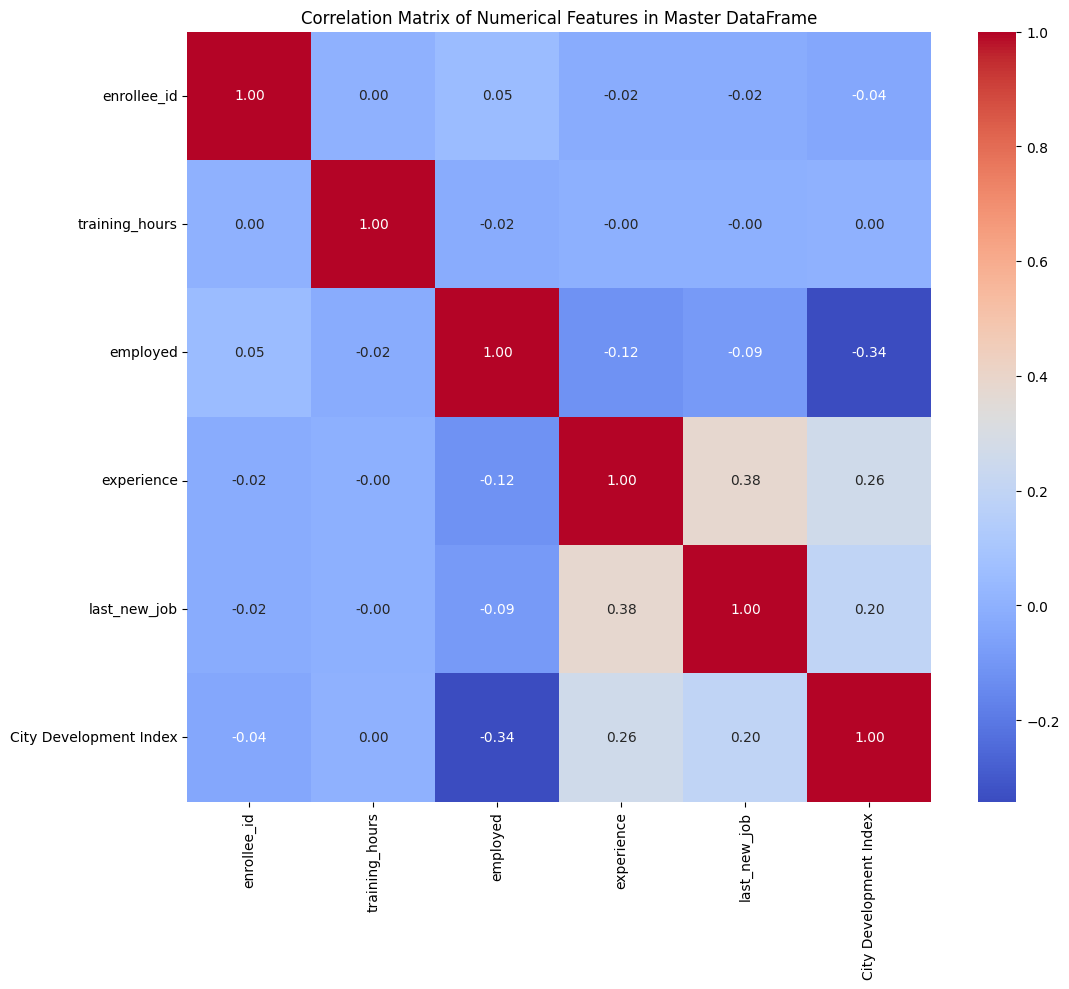

In [117]:
numerical_cols = master_df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numerical_cols.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features in Master DataFrame')
plt.show()

## Evaluate Heatmap

### Analysis of the Correlation Matrix:

Upon examining the heatmap of the numerical features in `master_df`, several key observations can be made:

**1. Correlations with 'employed' status:**
   - **City Development Index:** Shows a moderate negative correlation with 'employed' (-0.34). This suggests that individuals in cities with lower development indices might have a higher likelihood of being employed, or vice-versa.
   - **Experience:** Has a weak negative correlation with 'employed' (-0.12). This is counter-intuitive and suggests that more experience doesn't necessarily lead to higher employment in this dataset, or it might be related to the 'experience' categories not directly translating to linear employment probability.
   - **last_new_job:** Also shows a weak negative correlation with 'employed' (-0.09). This could imply that a longer duration since the last new job (higher 'last_new_job' value, meaning less recent job change) is slightly associated with lower employment, but the correlation is quite small.
   - **training_hours:** Exhibits a very weak negative correlation with 'employed' (-0.02), indicating almost no linear relationship.

**2. Strong Positive Correlations:**
   - There are no other strong positive correlations between distinct features that stand out significantly, apart from 'experience' and 'last_new_job' which have a moderate positive correlation of 0.38, suggesting that those with more overall experience tend to have a longer duration since their last new job (or less frequent job changes).

**3. Strong Negative Correlations:**
   - Apart from the 'City Development Index' and 'employed' correlation mentioned above (-0.34), there are no other strong negative correlations between distinct features. The strongest is between 'City Development Index' and 'employed' itself.

**4. Features with little to no correlation:**
   - **training_hours** has very low correlations with almost all other features, including 'employed' (0.00 to -0.02), suggesting it has minimal linear relationship with other numerical features in the dataset.

**Summary and Insights:**

The most notable correlation is the moderate negative relationship between `City Development Index` and `employed`. This suggests that the economic development of a city plays a role in employment status, though the inverse nature of the correlation is interesting and warrants deeper analysis (e.g., are people in less developed cities more likely to be employed in certain sectors, or is it a proxy for other unobserved factors?). The correlations involving 'experience' and 'last_new_job' with 'employed' are weak, implying that these numerical representations of experience may not be strong linear predictors of employment status on their own. Many features exhibit very low correlations, suggesting that a simple linear model might not capture the full complexity of their relationships, or that some features are largely independent of each other in a linear sense.

## Build OLS Regression Model


Prepare the data for the OLS model, I will first separate the target variable 'employed' from the features in `master_df` into `y` and `X` respectively.



In [118]:
y = master_df['employed']
X = master_df.drop('employed', axis=1)

In [119]:
categorical_cols = X.select_dtypes(include='string').columns.tolist()
print(f"Categorical columns identified: {categorical_cols}")

Categorical columns identified: ['full_name', 'city', 'gender', 'enrolled_university', 'education_level', 'major_discipline', 'relevent_experience', 'company_type', 'company_size_category']



To convert the identified categorical columns into a numerical format suitable for OLS regression, I will apply one-hot encoding using `pd.get_dummies()`.



In [120]:
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print("One-hot encoding applied to categorical columns.")


One-hot encoding applied to categorical columns.


To ensure that the OLS model includes an intercept term, I will add a constant to the feature DataFrame `X`.



In [121]:
X = sm.add_constant(X)
print("Constant term added to the feature DataFrame X.")

Constant term added to the feature DataFrame X.


Split the data into training, which will allow me to train the model on one portion and assess its accuracy on unseen data.



In [122]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data split into training and testing sets.")

Data split into training and testing sets.


Import the `OLS` class, instantiate it with the training data (`y_train` and `X_train`), and then fit the model. Finally, Print the model's summary to review its statistics and coefficients.



In [125]:
X = master_df.drop(['employed', 'enrollee_id', 'full_name'], axis=1)

categorical_cols = X.select_dtypes(include='string').columns.tolist()
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

X = X.astype(float) # Ensure all columns are numeric after one-hot encoding

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               employed   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     29.74
Date:                Mon, 15 Dec 2025   Prob (F-statistic):               0.00
Time:                        19:47:38   Log-Likelihood:                -6911.9
No. Observations:               15326   AIC:                         1.413e+04
Df Residuals:                   15173   BIC:                         1.530e+04
Df Model:                         152                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

## Evaluate OLS Regression Model

### Analysis of the OLS Regression Summary:

Looking at the OLS regression results, we can extract several key insights regarding the factors influencing the `employed` status:

**1. Model Fit:**
   - **R-squared (0.230)**: This indicates that approximately 23% of the variance in the `employed` status can be explained by the features included in the model. This is a relatively low value, suggesting that a significant portion of the variance remains unexplained by this linear model, and other factors or non-linear relationships might be at play.
   - **Adjusted R-squared (0.222)**: Similar to R-squared, it accounts for the number of predictors, and its closeness to R-squared suggests that the added predictors are somewhat useful, but the overall explanatory power is still limited.
   - **F-statistic (29.74) and Prob (F-statistic) (0.00)**: The highly significant F-statistic (p < 0.001) suggests that the model as a whole is statistically significant, meaning that at least one of the predictors is useful in explaining the `employed` status, despite the low R-squared.

**2. Significant Predictors (p-value < 0.05):**
   - **`training_hours`**: Has a small but significant negative coefficient (-0.0002, p=0.001). This implies that for each additional training hour, the likelihood of being employed slightly decreases, which is counter-intuitive and might warrant further investigation or could be indicative of selection bias (e.g., those already employed might have less need for additional training).
   - **`experience`**: Shows a small but significant negative coefficient (-0.0004, p=0.000). Similar to `training_hours`, this suggests that more overall experience (as represented by the transformed numerical variable) is associated with a slightly lower probability of being employed. This could be due to the transformation of the experience variable, or perhaps more experienced individuals are less likely to seek employment through the channels captured in this dataset, or face age-related biases.
   - **`last_new_job`**: Has a significant positive coefficient (0.0078, p=0.000). This indicates that a longer duration since the last new job (higher `last_new_job` value) is associated with a slightly higher probability of being employed. This is also somewhat counter-intuitive, as one might expect more recent job changes to indicate current employment, but it might relate to job stability or career progression patterns.
   - **`City Development Index`**: Shows a significant negative coefficient (-0.7857, p=0.001). This reinforces the observation from the heatmap: a higher city development index is associated with a lower probability of being employed. This is a strong relationship and suggests that employment opportunities, or the definition of 'employed' captured, might be higher in less developed cities, or there are other confounding factors.
   - **`city_city_XXX` (various city dummy variables)**: Many city dummy variables are statistically significant (e.g., `city_city_101`, `city_city_11`, `city_city_128`, `city_city_145`, `city_city_155`, `city_city_160`, `city_city_165`, `city_city_171`, `city_city_21`, `city_city_33`, `city_city_42`, `city_city_43`, `city_city_70`, `city_city_74`, `city_city_89`, `city_city_94`). This indicates that being in certain cities significantly impacts the employment status compared to the baseline city (which is implicitly included in the intercept).
   - **`enrolled_university_no_enrollment`**: Has a significant negative coefficient (-0.0477, p=0.000). This implies that individuals not enrolled in any university are less likely to be employed compared to the baseline (`Full time course` or `Part time course`).
   - **`education_level_High School` and `education_level_Primary School`**: Both have significant negative coefficients (-0.1464 and -0.1630, respectively, p=0.000). This suggests that individuals with only High School or Primary School education levels are less likely to be employed compared to the baseline education level (Graduate).
   - **`relevent_experience_No relevent experience`**: Has a significant positive coefficient (0.0246, p=0.004). This is quite interesting and implies that having no relevant experience is associated with a *higher* probability of being employed. This could indicate that the definition of 'relevent_experience' is specific, or that entry-level jobs (which might be filled by those with 'no relevant experience') are more readily available, or that 'Has relevant experience' implies a more specific job search that might be harder to satisfy.
   - **`company_type_Other` and `company_type_Public Sector`**: These categories show significant positive coefficients (0.0811, p=0.000 and 0.0514, p=0.030, respectively), indicating a higher likelihood of employment in these company types compared to the baseline (`Funded Startup`).
   - **`company_size_category_Small` and `company_size_category_Unknown`**: Both are significant positive predictors (0.0576, p=0.000 and 0.1733, p=0.000, respectively). Being in a 'Small' company or having an 'Unknown' company size is associated with a higher probability of being employed compared to the baseline (`Very Small`). The 'Unknown' category's large coefficient is notable.

**3. Features with little to no impact (p-value > 0.05):**
   - Many city dummy variables, gender categories, other `enrolled_university` categories, `education_level_Masters`, `education_level_Phd`, and most `major_discipline` categories are not statistically significant, suggesting they do not have a strong linear relationship with `employed` status in this model.

**4. Potential Issues:**
   - **`Cond. No. 7.29e+17`**: The extremely high condition number indicates severe multicollinearity. This means that some of the independent variables are highly correlated with each other, which can make the coefficient estimates unstable and difficult to interpret individually. While the model as a whole might still have predictive power, the individual P-values and coefficients might be unreliable.

**Summary:**
The OLS model identifies several statistically significant factors influencing employment status, particularly the City Development Index, education level, certain city locations, and company size/type. However, the overall explanatory power is low, and the presence of severe multicollinearity (high condition number) suggests that individual coefficients should be interpreted with caution.